In [46]:
from hdf5storage import loadmat, savemat
import numpy as np
import pickle

In [47]:
kn = loadmat('/home/tailai/data/knapsack/runB/kn_1_3_allneg_60_6_4.mat')
items = kn['items'][1]
n_con = kn['n_con'] 
n_items = kn['n_items'] 
n_obj = kn['n_obj'] 
n_selected = kn['n_selected'] 
capacity = kn['capacity']

In [48]:
rng = np.random.RandomState(123)
pop_size = 100_000

In [49]:
def best_ratio_item(items, obj_to_max):
    ratios = items[:, obj_to_max] / items[:, -1]
    sort_indices = np.argsort(ratios)
    best_item_index = sort_indices[-1]
    return best_item_index

In [50]:
pop_count = 0
population = np.zeros((pop_size, n_selected), dtype=np.int32)
objectives = np.zeros((pop_size, n_obj))
# seen_obj = set()  
while pop_count < pop_size:
    remain_ind = np.arange(n_items)
    knapsack_indices = np.zeros(n_selected, dtype=int)    
    knapsack = np.zeros((n_selected, (n_obj+n_con)))
    for n in range(0, n_selected):
        current_items = items[remain_ind, :]
        obj_to_max = rng.randint(n_obj) 
        choice_ind = best_ratio_item(current_items, obj_to_max)
        choice_ind_ori = remain_ind[choice_ind]
        knapsack_indices[n] = choice_ind_ori
        knapsack[n, :] = items[choice_ind_ori, :]
        remain_ind = np.delete(remain_ind, choice_ind) 
    
    constraint = np.sum(items[knapsack_indices, -1])
    if constraint <= capacity:
        # obj_vec = np.sum(knapsack[:, :n_obj], axis=0)
        # obj_key = tuple(obj_vec)
        # if obj_key not in seen_obj:
            # seen_obj.add(obj_key)
        population[pop_count, :] = knapsack_indices
        objectives[pop_count, :] = np.sum(knapsack[:, :n_obj], axis=0)
        pop_count += 1

In [51]:
objectives_unique = np.unique(objectives, axis=0)

In [52]:
objectives_unique.shape

(66, 4)

In [53]:
# with open('new_results_1_3_obj4_run1.pkl', 'rb') as f:
#     results = pickle.load(f)
# converged_pf = results['converged_pf_table'][-1]

In [54]:
converged_pf = kn['pareto_front_final'][1]

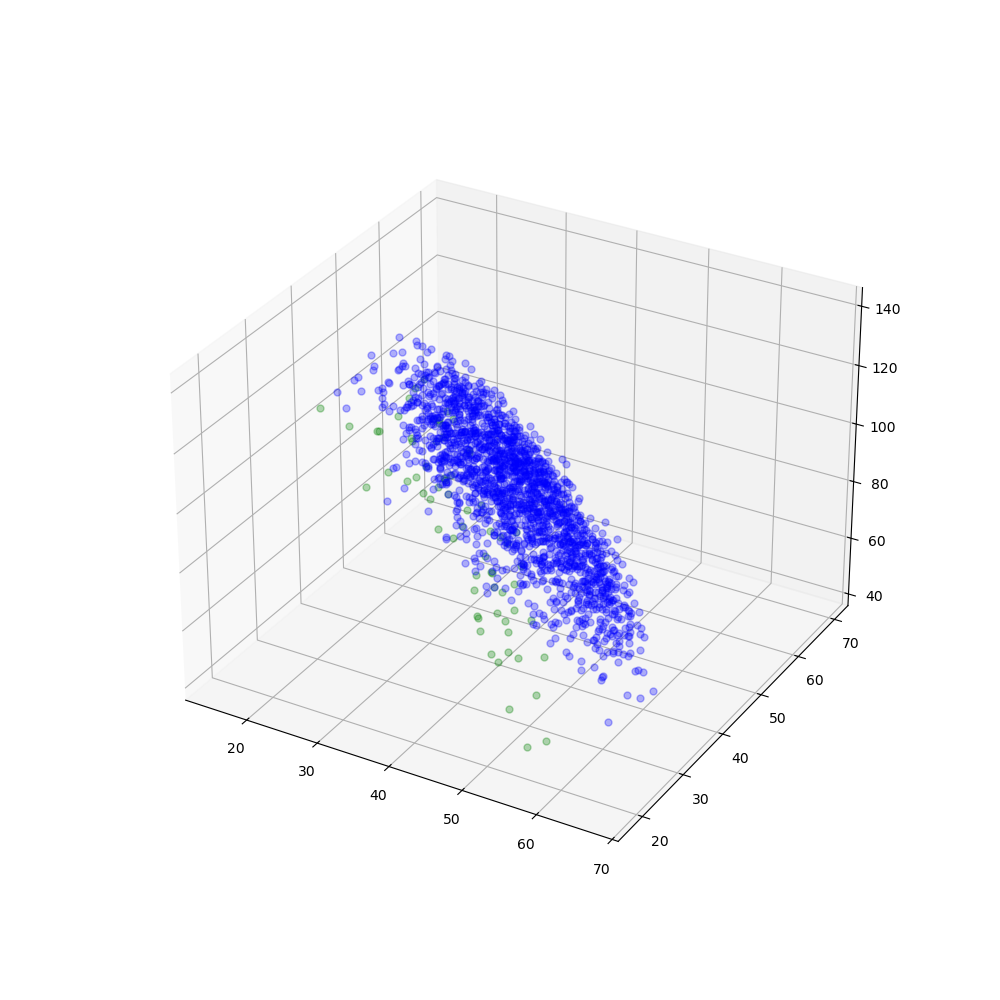

In [55]:
from matplotlib import pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(objectives_unique[:,0], objectives_unique[:,1], objectives_unique[:,2], 'go', alpha=0.3, markersize=5)
ax.plot(converged_pf[:,0], converged_pf[:,1], converged_pf[:,2], 'bo', alpha=0.3, markersize=5)
plt.show()

In [56]:
obj1 = objectives_unique[:, :n_obj]
obj2 = converged_pf[:, :n_obj]

In [ ]:
# use same number of solutions to compare
# change reference point

In [57]:
from pymoo.indicators.hv import HV

A = obj1.astype(np.float64)
B = obj2.astype(np.float64)
A_min = -A
B_min = -B

worst_min = np.max(np.vstack([A_min, B_min]), axis=0)
ref = worst_min * 1.05

hv = HV(ref_point=ref)

A_hv = hv(A_min)
B_hv = hv(B_min)

print(A_hv)
print(B_hv)
print((A_hv-B_hv)/B_hv)

1674516.7589999991
3633846.0050000045
-0.5391888493084348


In [58]:
# def eval_knapsack(knapsack,pf_actual,n_obj,scale,shape):
#     pf_predicted = knapsack
#     std_dev = np.sqrt(shape)*scale
#     count = 0 
#     pfdif = np.zeros(pf_actual.shape[0])
#     for j in range(pf_actual.shape[0]):
#         if np.any(pf_predicted[0:n_obj] > pf_actual[j,0:n_obj]):
#             count = count + 1
#         pfdif[j] = np.linalg.norm(pf_predicted[0:n_obj]/std_dev[0:n_obj] - pf_actual[j,0:n_obj]/std_dev[0:n_obj])
#     pf_difference = np.min(pfdif) 
#     domination_score = 1-count/pf_actual.shape[0]
#     return domination_score, pf_difference

In [59]:
# pf_difference = np.zeros(len(obj2))
# domination_score = np.zeros(len(obj2))
# for kk in range(len(obj2)):
#     domination_score[kk], pf_difference[kk] = eval_knapsack(obj2[kk], obj1, n_obj, kn['scale'],kn['shape'])

In [60]:
pf_predicted = obj1
pf_actual = obj2
dominated = np.zeros(len(pf_predicted))
for i in range(len(pf_predicted)):
    for j in range(len(pf_actual)):
        if np.all(pf_actual[j, :n_obj] >= pf_predicted[i, :n_obj]) and \
            np.any(pf_actual[j, :n_obj] > pf_predicted[i, :n_obj]):
            dominated[i] = 1
            break

In [61]:
np.sum(dominated)/len(pf_predicted)

0.8484848484848485